In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("search_filter").getOrCreate()
cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
print("You are working with {} cores".format(cores))

spark

You are working with 1 cores


In [7]:
path = "../../data/rec_crime_pfa.csv"

crime = spark.read.csv(path,inferSchema=True,header=True)

crime.limit(3).toPandas()

12 months ending                PFA      Region                    Offence  \
0       31/03/2003  Avon and Somerset  South West   All other theft offences   
1       31/03/2003  Avon and Somerset  South West              Bicycle theft   
2       31/03/2003  Avon and Somerset  South West  Criminal damage and arson   

   Rolling year total number of offences  
0                                  25959  
1                                   3090  
2                                  26202

In [3]:
crime.printSchema()

root
 |-- 12 months ending: string (nullable = true)
 |-- PFA: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Offence: string (nullable = true)
 |-- Rolling year total number of offences: integer (nullable = true)



In [8]:
crime.toPandas()

12 months ending                PFA      Region  \
0           31/03/2003  Avon and Somerset  South West   
1           31/03/2003  Avon and Somerset  South West   
2           31/03/2003  Avon and Somerset  South West   
3           31/03/2003  Avon and Somerset  South West   
4           31/03/2003  Avon and Somerset  South West   
...                ...                ...         ...   
46464       31/12/2018          Wiltshire  South West   
46465       31/12/2018          Wiltshire  South West   
46466       31/12/2018          Wiltshire  South West   
46467       31/12/2018          Wiltshire  South West   
46468       31/12/2018          Wiltshire  South West   

                                                 Offence  \
0                               All other theft offences   
1                                          Bicycle theft   
2                              Criminal damage and arson   
3      Death or serious injury caused by illegal driving   
4                                      Domestic burglary   
...                                                  ...   
46464                            Stalking and harassment   
46465                              Theft from the person   
46466                                   Vehicle offences   
46467                               Violence with injury   
46468                            Violence without injury   

       Rolling year total number of offences  
0                                      25959  
1                                       3090  
2                                      26202  
3                                          2  
4                                      14561  
...                                      ...  
46464                                   2380  
46465                                    347  
46466                                   2895  
46467                                   5701  
46468                                   5840  

[46469 rows x 5 columns]

#### SQL OPTION1 :: Dataframe

In [17]:
from pyspark.sql.types import *
from pyspark.sql.functions import *

crime = crime.withColumn("12 months ending",to_timestamp(crime["12 months ending"],format="dd/MM/yyyy"))
crime = crime.withColumnRenamed("12 months ending","12_months_ending")

In [27]:
#count number of offences given year

crime.groupBy("12_months_ending")\
        .agg(sum("Rolling year total number of offences"))\
        .orderBy("12_months_ending").toPandas()

12_months_ending  sum(Rolling year total number of offences)
0        2003-03-31                                     5974960
1        2004-03-31                                     6013759
2        2005-03-31                                     5637511
3        2006-03-31                                     5555172
4        2007-03-31                                     5427558
5        2007-06-30                                     5331397
6        2007-09-30                                     5213506
7        2007-12-31                                     5053088
8        2008-03-31                                     4952277
9        2008-06-30                                     4870476
10       2008-09-30                                     4837928
11       2008-12-31                                     4788657
12       2009-03-31                                     4702697
13       2009-06-30                                     4654592
14       2009-09-30                                     4554256
15       2009-12-31                                     4447490
16       2010-03-31                                     4338295
17       2010-06-30                                     4267799
18       2010-09-30                                     4223254
19       2010-12-31                                     4159914
20       2011-03-31                                     4150916
21       2011-06-30                                     4192243
22       2011-09-30                                     4253239
23       2011-12-31                                     4336452
24       2012-03-31                                     4379984
25       2012-06-30                                     4271597
26       2012-09-30                                     4192070
27       2012-12-31                                     4142326
28       2013-03-31                                     4063571
29       2013-06-30                                     4041108
30       2013-09-30                                     4022412
31       2013-12-31                                     4001090
32       2014-03-31                                     4028456
33       2014-06-30                                     4057038
34       2014-09-30                                     4087752
35       2014-12-31                                     4136897
36       2015-03-31                                     4167357
37       2015-06-30                                     4255225
38       2015-09-30                                     4325867
39       2015-12-31                                     4421168
40       2016-03-31                                     4509604
41       2016-06-30                                     4577820
42       2016-09-30                                     4678305
43       2016-12-31                                     4811414
44       2017-03-31                                     4976852
45       2017-06-30                                     5164515
46       2017-09-30                                     5338732
47       2017-12-30                                     5447811
48       2018-03-31                                     5516661
49       2018-06-30                                     5615514
50       2018-09-30                                     5723330
51       2018-12-31                                     5829016

<AxesSubplot:xlabel='year'>

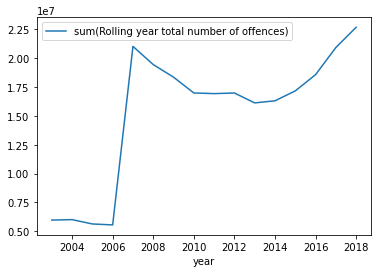

In [41]:
crime.select(year("12_months_ending").alias("year"),"Rolling year total number of offences")\
        .groupBy("year").sum("Rolling year total number of offences")\
        .orderBy("year").toPandas().set_index("year").plot()

#### SQL OPTION2 :: tempview

In [43]:
crime.createOrReplaceTempView("crime")

In [50]:
spark.sql("SELECT * FROM crime").printSchema()

#crime numbers based on region.

root
 |-- 12_months_ending: timestamp (nullable = true)
 |-- PFA: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Offence: string (nullable = true)
 |-- Rolling year total number of offences: integer (nullable = true)



In [55]:
spark.sql("""SELECT region,rolling_year_total_number_of_offences from crime""").show()

#lesson learned! you can't query column with spaces

AnalysisException: cannot resolve '`rolling_year_total_number_of_offences`' given input columns: [crime.12_months_ending, crime.Offence, crime.PFA, crime.Region, crime.Rolling year total number of offences]; line 1 pos 14;
'Project [region#60, 'rolling_year_total_number_of_offences]
+- SubqueryAlias crime
   +- Project [12 months ending#113 AS 12_months_ending#124, PFA#59, Region#60, Offence#61, Rolling year total number of offences#62]
      +- Project [to_timestamp(12 months ending#58, Some(dd/MM/yyyy)) AS 12 months ending#113, PFA#59, Region#60, Offence#61, Rolling year total number of offences#62]
         +- Relation[12 months ending#58,PFA#59,Region#60,Offence#61,Rolling year total number of offences#62] csv


In [65]:
crime = crime.withColumnRenamed("Rolling year total number of offences","total_number")

In [66]:
crime.createOrReplaceTempView("crime")

In [70]:
spark.sql("SELECT region, sum(total_number) FROM crime group by region order by 2 desc limit 5").show()

+--------------------+-----------------+
|              region|sum(total_number)|
+--------------------+-----------------+
|              London|         42691902|
|          South East|         30911995|
|          North West|         30235732|
|Yorkshire and The...|         23769180|
|       West Midlands|         21040955|
+--------------------+-----------------+



In [80]:
#depending on regions and year, calculate total_numer of crimes

spark.sql("""SELECT * FROM (SELECT 12_months_ending, region,total_number FROM crime group by 12_months_ending, region,total_number )
        PIVOT(
        SUM(total_number) as t 
        FOR region in ('London', 'South East', 'North West')
        
        )
        order by 12_months_ending
        
""").show()

+-------------------+-------+----------+----------+
|   12_months_ending| London|South East|North West|
+-------------------+-------+----------+----------+
|2003-03-31 00:00:00|1089903|    691115|    794964|
|2004-03-31 00:00:00|1070177|    733883|    820724|
|2005-03-31 00:00:00|1023679|    725780|    780087|
|2006-03-31 00:00:00| 992557|    728473|    781975|
|2007-03-31 00:00:00| 929751|    746010|    751262|
|2007-06-30 00:00:00| 913679|    728863|    724749|
|2007-09-30 00:00:00| 900534|    715110|    701903|
|2007-12-31 00:00:00| 883153|    694843|    678173|
|2008-03-31 00:00:00| 870205|    680588|    663141|
|2008-06-30 00:00:00| 863378|    669444|    653061|
|2008-09-30 00:00:00| 860363|    662196|    649594|
|2008-12-31 00:00:00| 859068|    657691|    638866|
|2009-03-31 00:00:00| 852311|    648784|    622910|
|2009-06-30 00:00:00| 851319|    642634|    607933|
|2009-09-30 00:00:00| 847271|    630085|    596225|
|2009-12-31 00:00:00| 839314|    615280|    576249|
|2010-03-31 

#### SQL OPTION 3 :: SQL TRANSFORMER

In [81]:
from pyspark.ml.feature import SQLTransformer

In [82]:
crime.columns

['12_months_ending', 'PFA', 'Region', 'Offence', 'total_number']

In [83]:
sqlTrans = SQLTransformer(statement="SELECT PFA, Region, Offence FROM __THIS__")


In [84]:
sqlTrans.transform(crime).show(5)

+-----------------+----------+--------------------+
|              PFA|    Region|             Offence|
+-----------------+----------+--------------------+
|Avon and Somerset|South West|All other theft o...|
|Avon and Somerset|South West|       Bicycle theft|
|Avon and Somerset|South West|Criminal damage a...|
|Avon and Somerset|South West|Death or serious ...|
|Avon and Somerset|South West|   Domestic burglary|
+-----------------+----------+--------------------+
only showing top 5 rows

